# Mô tả cấu trúc mô hình Random Forest bằng network

### BS. Lê Ngọc Khả Nhi

# Nhập đề

Chào các bạn, trong bài thực hành hôm nay Nhi sẽ giới thiệu với các bạn một ứng dụng khác của Network, đó là trình bày cấu trúc của một mô hình Random Forest. 

Chắc các bạn sẽ ngạc nhiên hỏi rằng: mô hình Random Forest thì có liên quan gì đến graph hay network ? Câu chuyện là như thế này: Ta có một tập hợp X gồm rất nhiều features và tạo ra một mô hình phân loại kết quả Y dựa vào các features này. Nếu đây là một mô hình Random Forest, nó hoạt động theo cơ chế tập hợp. Mô hình Random Forest là tập hợp của rất nhiều cây quyết định (decision tree), thí dụ 500 cây. Mỗi cây là một quy luật quyết định riêng, nhưng không sử dụng tất cả features mà chỉ một phần nhỏ trong số này. 

Ở trạng thái tối ưu, mô hình Random Forest chỉ giữ lại những features có vai trò quan trọng nhất và các features này nằm rải rác bên trong những cây quyết định. Việc một feature nào đó có số lần xuất hiện cao, có mặt trong hầu hết cây quyết định nghĩa là nó quan trọng. 

Mức độ quan trọng của mỗi feature có thể được khảo sát bằng variable importance, tuy nhiên phương pháp này không thể hiện được mối liên hệ giữa các features quan trọng với nhau: Một nhóm features tự nhiên sẽ có liên hệ với nhau khi cùng thuộc về cấu trúc của một decision tree. Ngoài việc tham gia một cách riêng lẻ, một feature có thể hợp tác với vài features khác tạo ra quy luật cho cây quyết định, và việc một nhóm features thường xuyên xuất hiện trong nhiều cây, cho thấy chúng là một tập hợp features quan trọng. 

Bằng network analysis, ta có thể khảo sát đồng thời vai trò đóng góp của từng feature và liên hệ giữa chúng. Trong network này, features là nodes, và một edge được hình thành giữa 2 features khi chúng cùng tham gia vào 1 cây quyết định. 

In [39]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 

import numpy as np
import pandas as pd

from numpy import random as nprand
import random
nprand.seed(100)
random.seed(100)

import networkx as nx

import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams.update({
    'figure.figsize': (15, 15),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})

# Bài toán mô phỏng

Nhi dùng tính năng mô phỏng dữ liệu cho bài toán classification của scikitlearn để tạo ra một bộ dữ liệu mô phỏng gồm 99 features, đặt tên là X1 đến X99, trong đó chỉ có 30 features thực sự quan trọng xác định nhãn của kết quả y

In [7]:
X, y = make_classification(n_samples=1000, n_features=99,
                           n_informative=30, n_redundant=5,
                           random_state=0, shuffle=False)

In [8]:
Xdf = pd.DataFrame(X, columns=['X'+ str(i+1) for i in range(99)])

Xdf.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
0,3.462962,5.628151,4.488086,1.396804,-0.889554,2.078864,-5.671543,1.956361,4.664227,-3.124281,...,-0.349118,1.326554,0.315760,0.734925,-0.330677,-0.079398,-1.454711,-0.975090,2.571861,-0.437246
1,-2.838654,-0.637757,3.606276,-4.726478,-2.642099,-6.435556,0.568123,3.080461,-5.602637,3.187399,...,-0.365935,0.773111,-0.808261,-1.810344,-0.442108,-0.931159,-0.619063,-1.683609,0.622535,1.800472
2,-4.919106,-1.595852,-1.777065,-0.857746,2.112761,-2.725796,0.119252,2.596656,2.535732,-2.061782,...,0.385292,1.059512,-0.192498,-0.795989,0.551896,0.107350,2.064428,-1.337988,2.143927,0.068410
3,-3.147257,-7.568612,-1.258002,-3.130901,-5.351344,1.822418,4.223145,-0.592883,-2.213313,2.246038,...,1.881735,1.149433,-0.018327,-1.165920,1.505795,2.761935,-0.794179,0.028772,-0.710777,-0.242499
4,2.881252,3.518284,2.474528,-3.492968,-2.570913,-1.860012,-2.305512,-2.075631,-0.145203,-3.449954,...,-0.307612,0.083934,-0.213276,-0.444384,1.113961,-0.537117,0.687873,0.621180,0.129590,-0.140080


Tiếp theo, ta dựng một mô hình RandomForest classifier trên tập X này, với 500 cây quyết định bên trong

In [9]:
clf = RandomForestClassifier(max_depth=5, random_state=0, n_estimators=500)
clf.fit(Xdf, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Những cây quyết định được lưu bên trong thuộc tính estimators_ của object mô hình:

In [13]:
clf.estimators_[0:3]

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=5, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=209652396, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=5, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=398764591, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=5, max_feature

Mỗi cây quyết định như vậy có dữ liệu về những features quan trọng nhất, và dữ liệu này nằm trong thuộc tính feature_importances_

In [14]:
clf.estimators_[99].feature_importances_

array([0.03399264, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06785122, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.15793902, 0.        , 0.        ,
       0.04026953, 0.03137482, 0.        , 0.04849086, 0.        ,
       0.08187362, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.010623  , 0.13627282, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04210834, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03273958, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01041175,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02062227, 0.03057012, 0.03600079,
       0.02739001, 0.        , 0.        , 0.02077975, 0.        ,
       0.        , 0.        , 0.        , 0.03306057, 0.        ,
       0.05951219, 0.0327568 , 0.        , 0.        , 0.     

Ta có thể thấy hầu hết features có importance score = 0.0, cho thấy chúng không hề tham gia vào quy luật của cây quyết định, cây thứ 99 này chỉ có 21 features là quan trọng.

In [19]:
sum(clf.estimators_[99].feature_importances_ > 0)

21

Bây giờ ta viết 1 hàm để chuyển thông tin về features importance thành network, hàm này nhận dữ liệu đầu vào là 1 mô hình random forest, danh sách features trong tập X, và ngưỡng features importance, thí dụ 0.15...

Network được tạo ra thuộc loại không định hướng (Graph), mỗi lần 1 feature xuất hiện trong 1 cây quyết định và có feature imprtance score lớn hơn ngưỡng quy định, nó sẽ được đưa vào network như 1 node, số lần feature này xuất hiện qua nhiều cây quyết định sẽ được cộng lại để tạo ra thuộc tính count, giá trị feature importance cũng được cộng lại để tạo ra thuộc tính score, cuối cùng thuộc tính avg_vimp là trung bình của feature importance = tổng score / tổng count.
Khi 2 features cùng có mặt trong 1 cây, 1 edge giữa 2 nodes được tạo ra, số lần bắt cặp này cũng được ghi nhận trong thuộc tính count, được xem như weight của edge.

In [59]:
def random_forest_to_network(rf_mod, features, thres = 0.1):
    
    G = nx.Graph()
    trees = rf_mod.estimators_
    
    for tree in trees:
        vimp_scores = tree.feature_importances_
        vimps = features[vimp_scores > thres]
        scores = vimp_scores[vimp_scores > thres]
        
        for v,s in zip(vimps,scores):
            try:
                G.nodes[v]['count'] += 1
                G.nodes[v]['score'] += s
            except KeyError:
                G.add_node(v)
                G.nodes[v]['count'] = 1
                G.nodes[v]['score'] = s
            for w in vimps:
                try:
                    G.edges[v, w]['count'] += 1
                except KeyError:
                    G.add_edge(v, w, count=1)
    
    for n,d in G.nodes(data = True):
        G.nodes[n]['avg_vimp'] = d['score']/d['count']
    
    return G

Ta áp dụng hàm này cho mô hình và danh sách X1-X99:

In [73]:
features = np.array(Xdf.columns)

G = random_forest_to_network(clf, features, thres = 0.13)

Ta thấy có 37 features (nodes) được đưa vào network

In [74]:
len(G.nodes)

37

Và có 123 cặp liên kết

In [75]:
len(G.edges)

123

Các thuộc tính của nodes:

In [76]:
G.nodes(data=True)

NodeDataView({'X13': {'count': 133, 'score': 25.47082490067042, 'avg_vimp': 0.19150996165917608}, 'X26': {'count': 17, 'score': 2.653347900709986, 'avg_vimp': 0.156079288277058}, 'X10': {'count': 166, 'score': 34.268973715060795, 'avg_vimp': 0.20643960069313733}, 'X32': {'count': 14, 'score': 2.131617813697247, 'avg_vimp': 0.15225841526408906}, 'X16': {'count': 35, 'score': 5.370729211423125, 'avg_vimp': 0.1534494060406607}, 'X29': {'count': 35, 'score': 5.505050132208825, 'avg_vimp': 0.15728714663453786}, 'X11': {'count': 25, 'score': 4.149074356118276, 'avg_vimp': 0.16596297424473103}, 'X7': {'count': 15, 'score': 2.280439449359999, 'avg_vimp': 0.15202929662399992}, 'X21': {'count': 11, 'score': 1.63518467186328, 'avg_vimp': 0.14865315198757093}, 'X2': {'count': 26, 'score': 3.9174910015754367, 'avg_vimp': 0.1506727308298245}, 'X12': {'count': 20, 'score': 3.1513835688089147, 'avg_vimp': 0.15756917844044574}, 'X65': {'count': 1, 'score': 0.1434145552394074, 'avg_vimp': 0.143414555239

Các thuộc tính của edges:

In [77]:
G.edges(data =True)

EdgeDataView([('X13', 'X13', {'count': 133}), ('X13', 'X10', {'count': 46}), ('X13', 'X32', {'count': 6}), ('X13', 'X16', {'count': 20}), ('X13', 'X65', {'count': 2}), ('X13', 'X7', {'count': 6}), ('X13', 'X1', {'count': 2}), ('X13', 'X12', {'count': 10}), ('X13', 'X3', {'count': 2}), ('X13', 'X29', {'count': 12}), ('X13', 'X26', {'count': 2}), ('X13', 'X25', {'count': 2}), ('X13', 'X11', {'count': 8}), ('X13', 'X96', {'count': 2}), ('X13', 'X2', {'count': 4}), ('X13', 'X24', {'count': 4}), ('X13', 'X4', {'count': 4}), ('X13', 'X21', {'count': 4}), ('X13', 'X49', {'count': 2}), ('X13', 'X28', {'count': 2}), ('X13', 'X20', {'count': 2}), ('X26', 'X26', {'count': 17}), ('X26', 'X12', {'count': 4}), ('X26', 'X34', {'count': 2}), ('X26', 'X11', {'count': 2}), ('X26', 'X32', {'count': 2}), ('X26', 'X88', {'count': 2}), ('X26', 'X2', {'count': 2}), ('X26', 'X18', {'count': 2}), ('X26', 'X10', {'count': 2}), ('X26', 'X29', {'count': 2}), ('X10', 'X10', {'count': 166}), ('X10', 'X32', {'count'

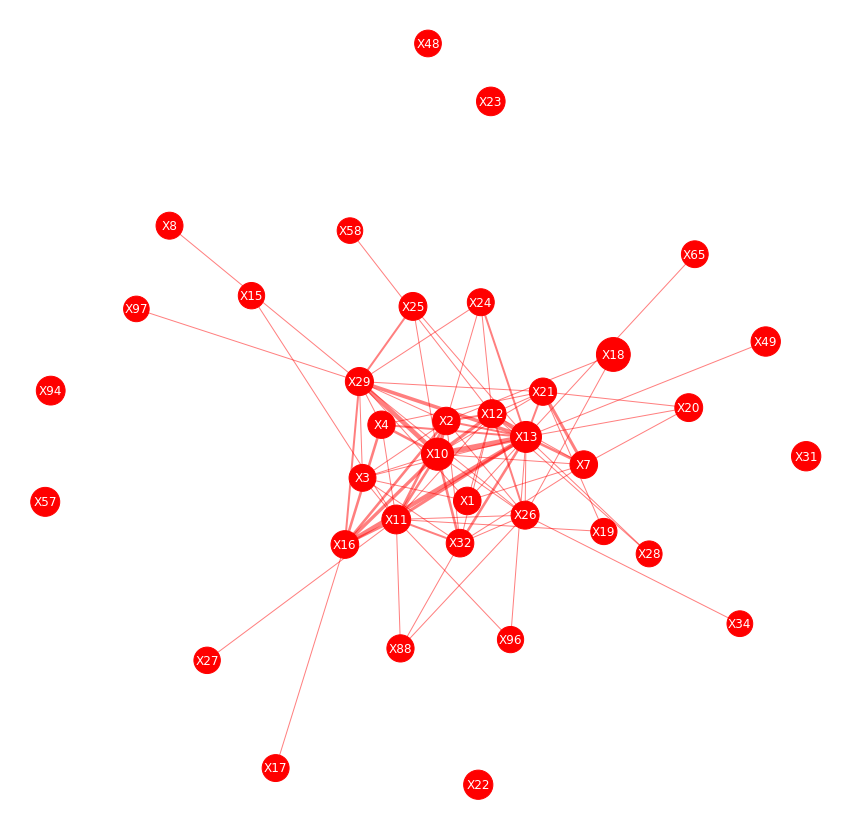

In [83]:
node_sizes = [5000*d['avg_vimp'] for n,d in G.nodes(data = True)]
weights = [np.log2(d['count']) for s, t, d in G.edges(data=True)]

pos=nx.spring_layout(G, k = 0.6)

nx.draw_networkx_nodes(G, pos, alpha=1.0, node_size = node_sizes , node_color = 'red')
nx.draw_networkx_labels(G, pos, font_size = 12, font_color = 'white')
nx.draw_networkx_edges(G, pos, edge_color="red", width = weights, alpha=0.5)

# Bài toán thực tế

Dataset heart disease được chọn để minh họa, nó chứa đồng thời biến định lượng và định tính.

Bộ dữ liệu này có thể tải từ kaggle hoặc thư mục Heartdisease tại github của Nhi. https://www.kaggle.com/ronitf/heart-disease-uci

Đây là một dataset cổ điển từng được dùng trong nhiều thí nghiệm machine learning về mô hình phân loại. Nó có cấu trúc dạng bảng (tabular) với 13 features và 1 outcome là biến nhị phân (chẩn đoán bệnh tim mạch).

age = tuổi
    
sex = giới tính (1:Nam,0:Nữ)

chest pain type : kiểu đau ngực (4 giá trị:

resting blood pressure = huyết áp khi nghỉ

serum cholesterol in mg/dl: nồng độ cholesterol máu

fasting blood sugar > 120 mg/dl: đường huyết cao (1 = có; 0 = không)

resting electrocardiographic results (values 0,1,2): điện tâm đồ lúc nghỉ (0 = bình thường, 1 = bất thường đoạn ST, 2 = dày thất trái)

maximum heart rate achieved: tần số tim cao nhất

exercise induced angina: đau ngực do gắng sức

oldpeak = ST depression induced by exercise relative to rest: dấu hiệu thiếu máu cơ tim trong test gắng sức, dựa vào đoạn ST của ECG

the slope of the peak exercise ST segment: kiểu hình của đoạn ST trong test gắng sức: phẳng, chênh xuống... (1: không chênh, 2: phẳng, Value 3: chênh xuống)

number of major vessels (0-3) colored by flourosopy : số mạch máu trên ảnh chụp cản quang

thal: 3 = normal; 6 = fixed defect; 7 = reversable defect : bệnh thalassemia (3 giá trị)

In [84]:
path = 'https://raw.githubusercontent.com/kinokoberuji/R-Tutorials/master/Heartdisease%20data/heart.csv'

df = pd.read_csv(path)

df.columns = ['Age', 
              'Sex', 
              'Chest_pain', 
              'Rest_BP', 
              'Cholesterol', 
              'FBS_test', 
              'Rest_ECG', 
              'Max_HR',
              'Ex_Angina', 
              'ST_depress', 
              'ST_slope', 
              'Vessel', 
              'Thalassemia', 
              'Target']

sex_dict = {0:'F', 1:'M'}
df['Sex'] = df['Sex'].map(sex_dict)

chest_pain_dict = {1:'typical',2:'atypical',3:'non-anginal',4:'asymptomatic'}
df['Chest_pain'] = df['Chest_pain'].map(chest_pain_dict)

FBS_dict = {0:'Low', 1:'High'}
df['FBS_test'] = df['FBS_test'].map(FBS_dict)

ECG_dict = {0:'Normal',1:'ST-T_Abnormal',2:'LV_hyper'}
df['Rest_ECG'] = df['Rest_ECG'].map(ECG_dict)

Angina_dict = {0:'N',1:'Y'}
df['Ex_Angina']=df['Ex_Angina'].map(Angina_dict)

ST_dict = {1:'Upsloping',2:'Flat',3:'Downsloping'}
df['ST_slope'] = df['ST_slope'].map(ST_dict)

Thalas_dict = {1:'Normal',2:'Fixed',3:'Reversable'}
df['Thalassemia'] = df['Thalassemia'].map(Thalas_dict)

df['Sex'] = df['Sex'].astype('object')
df['Chest_pain'] = df['Chest_pain'].astype('object')
df['FBS_test'] = df['FBS_test'].astype('object')
df['Rest_ECG'] = df['Rest_ECG'].astype('object')
df['Ex_Angina'] = df['Ex_Angina'].astype('object')
df['ST_slope'] = df['ST_slope'].astype('object')
df['Thalassemia'] = df['Thalassemia'].astype('object')

df = pd.get_dummies(df, drop_first=True)

df.head()

,Age,Rest_BP,Cholesterol,Max_HR,ST_depress,Vessel,Target,Sex_M,Chest_pain_non-anginal,Chest_pain_typical,FBS_test_Low,Rest_ECG_Normal,Rest_ECG_ST-T_Abnormal,Ex_Angina_Y,ST_slope_Upsloping,Thalassemia_Normal,Thalassemia_Reversable
0,63,145,233,150,2.3,0,1,1,1,0,0,1,0,0,0,1,0
1,37,130,250,187,3.5,0,1,1,0,0,1,0,1,0,0,0,0
2,41,130,204,172,1.4,0,1,0,0,1,1,1,0,0,0,0,0
3,56,120,236,178,0.8,0,1,1,0,1,1,0,1,0,0,0,0
4,57,120,354,163,0.6,0,1,0,0,0,1,0,1,1,0,0,0


In [85]:
Xdf = df.drop('Target', 1)
y = df['Target']
features = np.array(Xdf.columns)

In [86]:
clf = RandomForestClassifier(max_depth=5, 
                             random_state=123, 
                             n_estimators=500,
                            n_jobs = -1)

clf.fit(Xdf, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [89]:
features = np.array(Xdf.columns)

G = random_forest_to_network(clf, features, thres = 0.15)

Làm tương tự như trên, với ngưỡng variable importance = 0.15, ta có kết quả network như sau:

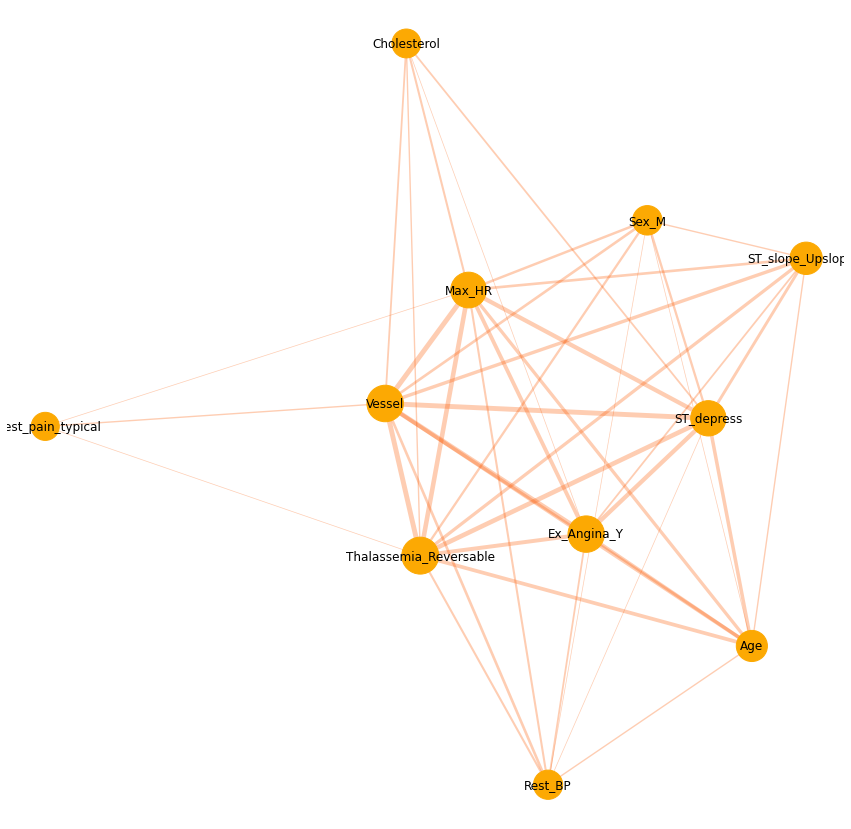

In [92]:
node_sizes = [5000*d['avg_vimp'] for n,d in G.nodes(data = True)]
weights = [np.log(d['count']) for s, t, d in G.edges(data=True)]

pos=nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, alpha=1.0, node_size = node_sizes , node_color = '#fca903')
nx.draw_networkx_labels(G, pos, font_size = 12, font_color = 'black')
nx.draw_networkx_edges(G, pos, edge_color='#fc5a03',width = weights, alpha=0.3)

Bài thực hành đến đây là hết, các bạn lại biết thêm một ứng dụng nữa của network và graph rồi đó. Chúc các bạn thực hành vui và hẹn gặp lại lần sau